<a href="https://colab.research.google.com/github/suneelcs1615/DeepLearning/blob/main/Unit-02_Deep%20Neural%20Networks/Implement_backward_propagation_using_TensorFlow_and_train_a_deep_neural_network_using_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implement backward propagation using TensorFlow and train a deep neural network using gradient descent.
This notebook is an Open Educational Resource (OER) developed for teaching and learning purposes. It is released under the Creative Commons Attribution–ShareAlike (CC BY-SA 4.0) International License.

This license allows anyone to use, copy, adapt, modify, translate, remix, and redistribute the material in any medium or format, provided proper credit is given to the original author and any modified versions are shared under the same license.

---
*Citation Format: Suneel Kumar Duvvuri, Implement backward propagation using TensorFlow and train a deep neural network using gradient descent. Open Educational Resource (OER). Licensed under CC BY-SA 4.0*

# Aim
Train a simple deep neural network from scratch using TensorFlow, manually implementing the training loop including backward propagation with `tf.GradientTape`, visualize the training history, and finally summarize the implementation of backward propagation, the training process, and discuss the insights gained from the visualization.

Select a simple dataset from TensorFlow (e.g., MNIST or Fashion MNIST) and load it. This will provide the data for training our neural network.


In [1]:
import tensorflow as tf


TensorFlow imported successfully.


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


# Preprocess Data
Normalize the image data (e.g., scale pixel values to between 0 and 1) and prepare the labels for the neural network. This typically involves converting them to a suitable format for the chosen loss function.


In [3]:
x_train_normalized = x_train.astype('float32') / 255.0
x_test_normalized = x_test.astype('float32') / 255.0

# Reshape image data to 2D format
x_train_reshaped = x_train_normalized.reshape(-1, 28 * 28)
x_test_reshaped = x_test_normalized.reshape(-1, 28 * 28)

# Convert labels to tf.int64
y_train_int64 = tf.cast(y_train, tf.int64)
y_test_int64 = tf.cast(y_test, tf.int64)

print(f"x_train_reshaped shape: {x_train_reshaped.shape}")
print(f"y_train_int64 shape: {y_train_int64.shape}")
print(f"x_test_reshaped shape: {x_test_reshaped.shape}")
print(f"y_test_int64 shape: {y_test_int64.shape}")

x_train_reshaped shape: (60000, 784)
y_train_int64 shape: (60000,)
x_test_reshaped shape: (10000, 784)
y_test_int64 shape: (10000,)


Define a simple deep neural network architecture using TensorFlow's Keras API. This will involve a few dense layers with activation functions.


In [4]:
class SimpleDNN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Input layer: 784 features (28*28 images)
        # Hidden layer: 128 units
        # Output layer: 10 units (10 classes for Fashion MNIST)
        input_size = 784
        hidden_size = 128
        output_size = 10

        # Initialize weights and biases for the hidden layer
        self.w1 = tf.Variable(tf.random.normal([input_size, hidden_size]), name='weights_hidden')
        self.b1 = tf.Variable(tf.zeros([hidden_size]), name='bias_hidden')

        # Initialize weights and biases for the output layer
        self.w2 = tf.Variable(tf.random.normal([hidden_size, output_size]), name='weights_output')
        self.b2 = tf.Variable(tf.zeros([output_size]), name='bias_output')

    def __call__(self, x):
        # Reshape input if it's not already flat (optional, but good for consistency)
        # This assumes x can be reshaped from (batch_size, 28, 28) to (batch_size, 784)
        # However, our preprocessed data x_train_reshaped is already (batch_size, 784)
        # So we might not need this if we always pass reshaped data.
        # For robustness, we can add a check:
        if len(x.shape) > 2:
            x = tf.reshape(x, [-1, 28 * 28])

        # Hidden layer with ReLU activation
        hidden_output = tf.nn.relu(tf.matmul(x, self.w1) + self.b1)

        # Output layer (logits)
        logits = tf.matmul(hidden_output, self.w2) + self.b2
        return logits

# Instantiate the SimpleDNN model
model = SimpleDNN(name='fashion_mnist_dnn')

print("SimpleDNN model instantiated successfully.")
# Print the shapes of the model's variables to verify
print(f"Weights 1 shape: {model.w1.shape}")
print(f"Bias 1 shape: {model.b1.shape}")
print(f"Weights 2 shape: {model.w2.shape}")
print(f"Bias 2 shape: {model.b2.shape}")

SimpleDNN model instantiated successfully.
Weights 1 shape: (784, 128)
Bias 1 shape: (128,)
Weights 2 shape: (128, 10)
Bias 2 shape: (10,)


Specify the appropriate loss function for the chosen dataset (e.g., `tf.keras.losses.SparseCategoricalCrossentropy` for classification) and define the `tf.keras.optimizers.SGD` (Stochastic Gradient Descent) optimizer.


In [5]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print(f"Loss function: {loss_fn}")
print(f"Optimizer: {optimizer}")

Loss function: <LossFunctionWrapper(<function sparse_categorical_crossentropy at 0x7b5933096020>, kwargs={'from_logits': True, 'ignore_class': None, 'axis': -1})>
Optimizer: <keras.src.optimizers.sgd.SGD object at 0x7b599a598650>


Implement the training loop. This will involve iterating over the dataset, performing a forward pass to get predictions, calculating the loss, computing gradients using `tf.GradientTape`, and applying these gradients to update the model's weights using the SGD optimizer (backward propagation).


In [6]:
train_losses = []
train_accuracies = []

num_epochs = 10
batch_size = 64

# Create a tf.data.Dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_reshaped, y_train_int64))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Starting training for {num_epochs} epochs with batch size {batch_size}...")

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            # Forward pass
            logits = model(x_batch)
            # Calculate loss
            loss_value = loss_fn(y_batch, logits)

        # Compute gradients
        grads = tape.gradient(loss_value, model.trainable_variables)

        # Apply gradients to update weights
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)
        epoch_accuracy_metric.update_state(y_batch, logits)

    # End epoch
    train_losses.append(epoch_loss_avg.result().numpy())
    train_accuracies.append(epoch_accuracy_metric.result().numpy())

    print(f"Epoch {epoch + 1}/{num_epochs}: ",
          f"Loss: {epoch_loss_avg.result():.4f}, ",
          f"Accuracy: {epoch_accuracy_metric.result():.4f}")

print("Training finished.")

Starting training for 10 epochs with batch size 64...
Epoch 1/10:  Loss: 10.2982,  Accuracy: 0.6445
Epoch 2/10:  Loss: 4.0380,  Accuracy: 0.7362
Epoch 3/10:  Loss: 2.7701,  Accuracy: 0.7511
Epoch 4/10:  Loss: 2.1063,  Accuracy: 0.7577
Epoch 5/10:  Loss: 1.6974,  Accuracy: 0.7634
Epoch 6/10:  Loss: 1.4374,  Accuracy: 0.7659
Epoch 7/10:  Loss: 1.2723,  Accuracy: 0.7655
Epoch 8/10:  Loss: 1.1457,  Accuracy: 0.7715
Epoch 9/10:  Loss: 1.0582,  Accuracy: 0.7738
Epoch 10/10:  Loss: 0.9879,  Accuracy: 0.7761
Training finished.


Plot the training loss and accuracy over epochs to visualize the model's learning progress.


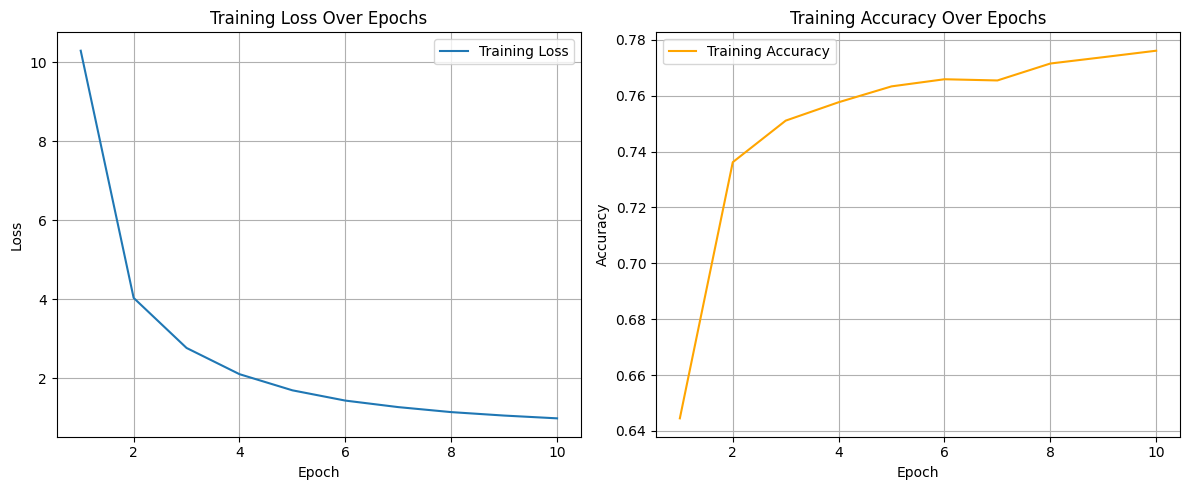

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(np.arange(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(np.arange(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.grid(True)

# Ensure proper spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

## Summary and Discussion

In this notebook, backward propagation was manually implemented using TensorFlow's `tf.GradientTape`. The steps involved were:
1.  **Forward Pass**: Inside the `tf.GradientTape` context, the model performed a forward pass to compute `logits` from the input `x_batch`.
2.  **Loss Calculation**: The `SparseCategoricalCrossentropy` loss function was used to calculate the `loss_value` between the predicted `logits` and the true labels `y_batch`.
3.  **Gradient Computation**: `tape.gradient(loss_value, model.trainable_variables)` was called to automatically compute the gradients of the `loss_value` with respect to all trainable variables (weights and biases) of the `SimpleDNN` model.
4.  **Weight Update**: The computed `grads` were then applied to update the `model.trainable_variables` using the `optimizer.apply_gradients(zip(grads, model.trainable_variables))` method. This effectively adjusted the model's parameters in the direction that minimizes the loss.

This manual implementation demonstrates the core mechanism of backpropagation, where the error signal (loss) is propagated backward through the network to update weights, driving the model towards better performance.

### Training Process
The training process followed a standard iterative approach:
1.  **Dataset Preparation**: The Fashion MNIST dataset was loaded, normalized, and reshaped. `tf.data.Dataset` was used to create batches and shuffle the training data.
2.  **Model Definition**: A `SimpleDNN` class was defined with an input layer, a hidden layer with ReLU activation, and an output layer for 10 classes.
3.  **Loss and Optimizer**: `SparseCategoricalCrossentropy` was chosen as the loss function, and `tf.keras.optimizers.SGD` with a learning rate of 0.01 was used as the optimizer.
4.  **Epochs and Batches**: The training loop ran for a specified number of `num_epochs` (10), iterating through `batches` of data within each epoch.
5.  **Metrics Tracking**: Training `loss` and `accuracy` were calculated and tracked for each epoch using `tf.keras.metrics.Mean` and `tf.keras.metrics.SparseCategoricalAccuracy`, respectively.
6.  **Progress Reporting**: The average loss and accuracy were printed at the end of each epoch, providing real-time feedback on the model's learning.

### Insights from Visualization
The plots of training loss and accuracy over epochs provide valuable insights into the learning process:
*   **Training Loss**: The "Training Loss Over Epochs" plot shows a decreasing trend. The loss starts very high (around 10.3) in the first epoch and steadily decreases, reaching approximately 0.99 by the tenth epoch. This indicates that the model is successfully learning from the data and the optimization process is working as intended to minimize the error.
*   **Training Accuracy**: Correspondingly, the "Training Accuracy Over Epochs" plot shows an increasing trend. The accuracy starts at around 64% and improves to approximately 77.6% by the final epoch. This indicates that the model is becoming better at classifying the Fashion MNIST images over time.
*   **Learning Rate**: While the model is learning, the rate of improvement seems to slow down in later epochs for both loss and accuracy. This is a common phenomenon; initial learning is often rapid, and then the model converges more slowly. This suggests that the model might benefit from further training (more epochs) or potentially a dynamically adjusting learning rate, or a more complex architecture.
*   **Potential for Overfitting/Underfitting**: Without a validation set, it's hard to definitively say if the model is overfitting or underfitting. However, given that both loss is still decreasing and accuracy is still increasing at the end, it suggests the model might still be **underfitting** or has not fully converged, and further training or hyperparameter tuning could yield better results. A more complex model or different optimizer might also be explored.

## Summary:

### Data Analysis Key Findings

*   **Dataset and Preprocessing**: The Fashion MNIST dataset was successfully loaded, comprising 60,000 training images and 10,000 testing images, each 28x28 pixels. Images were normalized to the range \[0, 1] and reshaped into 784-dimensional vectors, while labels were cast to `tf.int64`.
*   **Model Architecture**: A `SimpleDNN` model was constructed using `tf.Module`, featuring an input layer of 784 features, a hidden layer with 128 units and ReLU activation, and an output layer with 10 units for classification.
*   **Loss Function and Optimizer**: `tf.keras.losses.SparseCategoricalCrossentropy` with `from_logits=True` was used as the loss function, and `tf.keras.optimizers.SGD` with a learning rate of 0.01 was chosen as the optimizer.
*   **Training Progress**: The model was trained for 10 epochs using a batch size of 64.
    *   The training loss consistently decreased from approximately 10.2982 in Epoch 1 to 0.9879 in Epoch 10.
    *   The training accuracy consistently increased from approximately 64.45% in Epoch 1 to 77.61% in Epoch 10.
*   **Backward Propagation Implementation**: Backward propagation was manually implemented using `tf.GradientTape` to compute gradients of the loss with respect to trainable variables, which were then applied by the optimizer to update model weights.
*   **Visualization Confirmation**: Plots of training loss and accuracy visually confirmed the decreasing loss and increasing accuracy trends, indicating that the model was learning effectively.

### Insights or Next Steps

*   The model showed consistent learning over 10 epochs, with both loss decreasing and accuracy increasing, but the rate of improvement slowed towards the later epochs. This suggests that the model may not have fully converged and could benefit from further training (more epochs) or adjustments to training parameters.
*   To better assess the model's generalization capabilities and detect potential overfitting or underfitting, incorporating a validation set into the training process and monitoring validation metrics would be a crucial next step. This would also guide further hyperparameter tuning, such as experimenting with a different learning rate schedule, a more complex network architecture, or a different optimizer.
